In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['av_innoplex_nlp_sentiment_analysis']


In [2]:
from fastai.text import *
from fastai.callbacks import *
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
seed = 7
np.random.seed(seed)
output_dir = 'model_output_fastai'
path = "../input/av_innoplex_nlp_sentiment_analysis/AV_Innoplex_NLP_sentiment_Analysis"

In [4]:
data_lm = (TextList.from_csv(path=path+'/TrainSet/',csv_name='train_F3WbcTw.csv',cols='text')
       .split_by_rand_pct()
       .label_for_lm()
       .databunch(bs=16)
       )
# data_lm.save('tmp_lm')
data_lm.show_batch()

idx,text
0,") and i do n’t know if it will last a month , a year , a decade , i ve just decided to enjoy the ride , no point in worrying . xxbos i can completely understand why you ’d want to try it . xxmaj but , results reported in xxunk do n’t always stand up to the xxunk of peer - review during publication . xxmaj there"
1,"xxmaj greetings everyone . xxmaj newbie here . i was diagnosed xxup nsclc in xxmaj december 2017 when a lung mass was discovered on a xxup pet scan which was done for a workup of a xxup gyn malignancy . i had no symptoms . a mass of 1.5 by 2 cm in my r lung with hilar and xxunk nodes , a xxunk node , and xxunk nodes ."
2,"useful when discussing treatment options with your healthcare provider and advocating with insurers for access and coverage . xxmaj this paper was last updated in 2016 . xxmaj adhering to your disease - modifying medication is a key element of treatment effectiveness . xxmaj for help in managing the costs of these medications , read about the patient assistance programs offered by the pharmaceutical companies . xxmaj under certain circumstances"
3,". xxmaj the new packaging has xxunk praise for not only being simple to use , but also xxunk . xxmaj the applicator is actually the product ’s cap , and comes in the form of a pull / push mechanism made from plastic . xxmaj according to xxup gsk global packaging development manager xxmaj xxunk xxmaj xxunk , the nature of this mechanism helps reduce xxunk risks , as"
4,an anti - xxup tnf drug for treatment of perianal fistula or intestinal xxmaj crohn 's ... xxmaj added 9 months ago xxmaj study xxmaj to xxmaj test xxmaj whether xxup pf-00547659 xxmaj is xxmaj safe xxmaj and xxmaj improves xxmaj disease xxmaj symptoms xxmaj in xxmaj patients xxmaj with xxmaj crohn 's xxmaj disease ( xxup opera ) xxmaj adults with xxmaj crohn 's disease that is clinically active


In [5]:
test_datalist = TextList.from_csv(path=path+'/TestSet/',csv_name='test_tOlRoBf.csv',cols='text',vocab=data_lm.vocab)
data_classifier = (TextList.from_csv(path=path+'/TrainSet/',csv_name='train_F3WbcTw.csv',cols='text',vocab=data_lm.vocab)
       .split_by_rand_pct()
       .label_from_df(cols='sentiment')
       .add_test(test_datalist)
       .databunch(bs=32)
       )
data_classifier.show_batch()

text,target
"xxbos xxmaj written xxmaj january 12 , 2018 xxmaj next : xxmaj let xxmaj us xxmaj try xxmaj home xxmaj ratings xxmaj rate this xxmaj summary xxmaj current xxmaj average xxmaj ratings xxmaj overall quality xxmaj avg : 0 / 5 xxmaj applies to topic xxmaj avg : 0 / 5 xxmaj helpful to me xxmaj avg : 0 / 5 xxmaj underwhelmed xxmaj total xxmaj avg xxmaj rating :",2
xxbos m protein xxmaj an antibody or part of an antibody found in unusually large amounts in the blood or urine of people with multiple myeloma and other types of plasma cell tumors . xxmaj also called monoclonal protein . m - xxup xxunk xxmaj minocycline - xxup xxunk . a substance being studied in the treatment of bacterial infections from catheters ( flexible tubes used to deliver fluids into,2
"xxbos xxmaj the lungs are a pair of cone - shaped breathing organs in the chest . xxmaj the lungs bring oxygen into the body as you breathe in . xxmaj they release carbon dioxide , a waste product of the body ’s cells , as you breathe out . xxmaj each lung has sections called lobes . xxmaj the left lung has two lobes . xxmaj the right lung",2
xxbos . xxmaj immunotherapy . xxmaj checkpoint inhibitors . xxmaj anti – programmed cell death-1 ( xxup pd-1 ) and programmed death - ligand 1 ( xxup pd - xxup l1 ) . xxmaj pembrolizumab . xxmaj nivolumab . xxmaj anti – cytotoxic t - lymphocyte antigen-4 ( xxup ctla-4 ) . xxmaj ipilimumab . xxmaj high - dose interleukin-2 ( xxup il-2 ) . xxmaj dual immunomodulation . xxmaj,2
xxbos xxmaj childhood rhabdomyosarcoma is a disease in which malignant ( cancer ) cells form in muscle tissue . xxmaj certain genetic conditions increase the risk of childhood rhabdomyosarcoma . a sign of childhood rhabdomyosarcoma is a lump or swelling that keeps getting bigger . xxmaj diagnostic tests and a biopsy are used to detect ( find ) and diagnose childhood rhabdomyosarcoma . xxmaj certain factors affect prognosis ( chance,2


In [6]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.model_dir = '/kaggle/working'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 2.09E-02


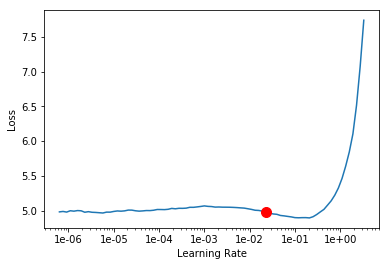

In [7]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
learn.fit_one_cycle(5, 1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.950573,3.754909,0.322792,02:00


In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
learn.fit_one_cycle(10, 1e-3,moms=(0.8,0.7))

In [ ]:
learn.save_encoder('ft_enc')

In [ ]:
learn = text_classifier_learner(data_classifier, AWD_LSTM, drop_mult=0.2)
learn.load_encoder('ft_enc')
learn.callback_fns = [ShowGraph,partial(SaveModelCallback, monitor='accuracy', name='best_model')]
learn.model_dir = '/kaggle/working'

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
lr = 1e-2
learn.fit_one_cycle(3,slice(lr), moms=(0.8, 0.7))

In [ ]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
learn.fit_one_cycle(3, slice(5e-5/(2.6**4), 5e-5),moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
learn.fit_one_cycle(3, slice(5e-5/(2.6**4), 5e-5),moms=(0.8,0.7))

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
learn.fit_one_cycle(5, slice(2e-5/(2.6**4), 2e-5),moms=(0.8,0.7))

In [ ]:
learn.load('best_model')

In [ ]:
interpreter = ClassificationInterpretation.from_learner(learn)
interpreter.plot_confusion_matrix()

In [ ]:
preds, target = learn.get_preds(DatasetType.Valid, ordered=True)
valid_preds = np.argmax(preds, axis =1)

In [ ]:
from sklearn.metrics import f1_score
# f1 score
score = f1_score(valid_preds, target,average='macro')

# print
print ("F1 score: {:.6f}".format(score))

In [ ]:
preds, target = learn.get_preds(DatasetType.Test, ordered=True)
labels = np.argmax(preds, axis =1)

In [ ]:
test_id = test_df['unique_hash']

In [ ]:
submission = pd.DataFrame({'unique_hash': test_id, 'sentiment': labels})
submission.to_csv('submission_v2_kaggle.csv', index=False)
submission.head()